# Aplicación de espacio y subespacio vectorial al reconocimineto facial (Eugenface method)
1. Formar un subespacio vectorial con el conjunto de rostros conocidos denominado "subespacio de rostros"
2. Creamos una base para el espacio vectorial de manera que los vectores base generean span del subespacio.
3. La base anterior estara compuesta vectores singulares del conjunto de rostros conocidos.
4. Estos vectores corresponden a vectores numéricos que representan las características comunes del subespacio.
5. Proyectar la nueva imagen con las proyecciones disponibles de rostros conocidos para identificar el rostro de una persona

## Autores 
- Sergio Cardenas
- Fernanod Sanchez

# Explicacion
El algoritmo de reconocimiento facial basado en la descomposición de valores singulares (SVD) funciona al proyectar las imágenes de los rostros en un espacio vectorial que captura las características esenciales de los rostros previamente conocidos.
1. Las imágenes se transforman a escala de grises y se convierten en vectores.
2. Después, se ajustan restando el promedio del conjunto de entrenamiento, creando una matriz A donde cada columna representa una de estas imágenes ajustadas.
3. Despues de aplicar SVD a esta matriz, se obtienen vectores singulares que establecen una base ortonormal para el espacio que define los rostros.
4. Las posiciones de cada rostro dentro de este espacio se determinan proyectando las imágenes sobre los vectores singulares. 

Para identificar un nuevo rostro, se proyecta en el mismo espacio y se calcula la distancia entre este nuevo rostro y los ya conocidos. Si la distancia es menor a un valor umbral previamente establecido, se clasifica como un rostro conocido; de lo contrario, se considera desconocido.

Este algoritmo puede diferenciar los rostros debido a que las imágenes proyectadas en el espacio vectorial contienen las características compartidas y únicas de los rostros conocidos. 

# Desarrollo

In [4]:
# importaciones
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def load_image(img_path: str) -> None:
  img = cv2.imread(img_path)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [6]:
def show_grid_images(list_images:list)->None:
  fig = plt.figure(figsize=(15, 15))
  for i in range(len(list_images)):
    ax = fig.add_subplot(6, 6, i+1, xticks=[], yticks=[])
    ax.imshow(list_images[i], cmap=plt.cm.bone)
    ax.set_title(i, fontsize='small', color='black')

In [7]:
abs_path = os.getcwd()
train_folder = 'img_train'
test_folder = 'img_test'

train_files = [os.path.join(abs_path, train_folder, x) for x in os.listdir(os.path.join(abs_path, train_folder))]
test_files = [os.path.join(abs_path, test_folder, x) for x in os.listdir(os.path.join(abs_path, test_folder))]

# 1. Cargado de imágenes de rostros

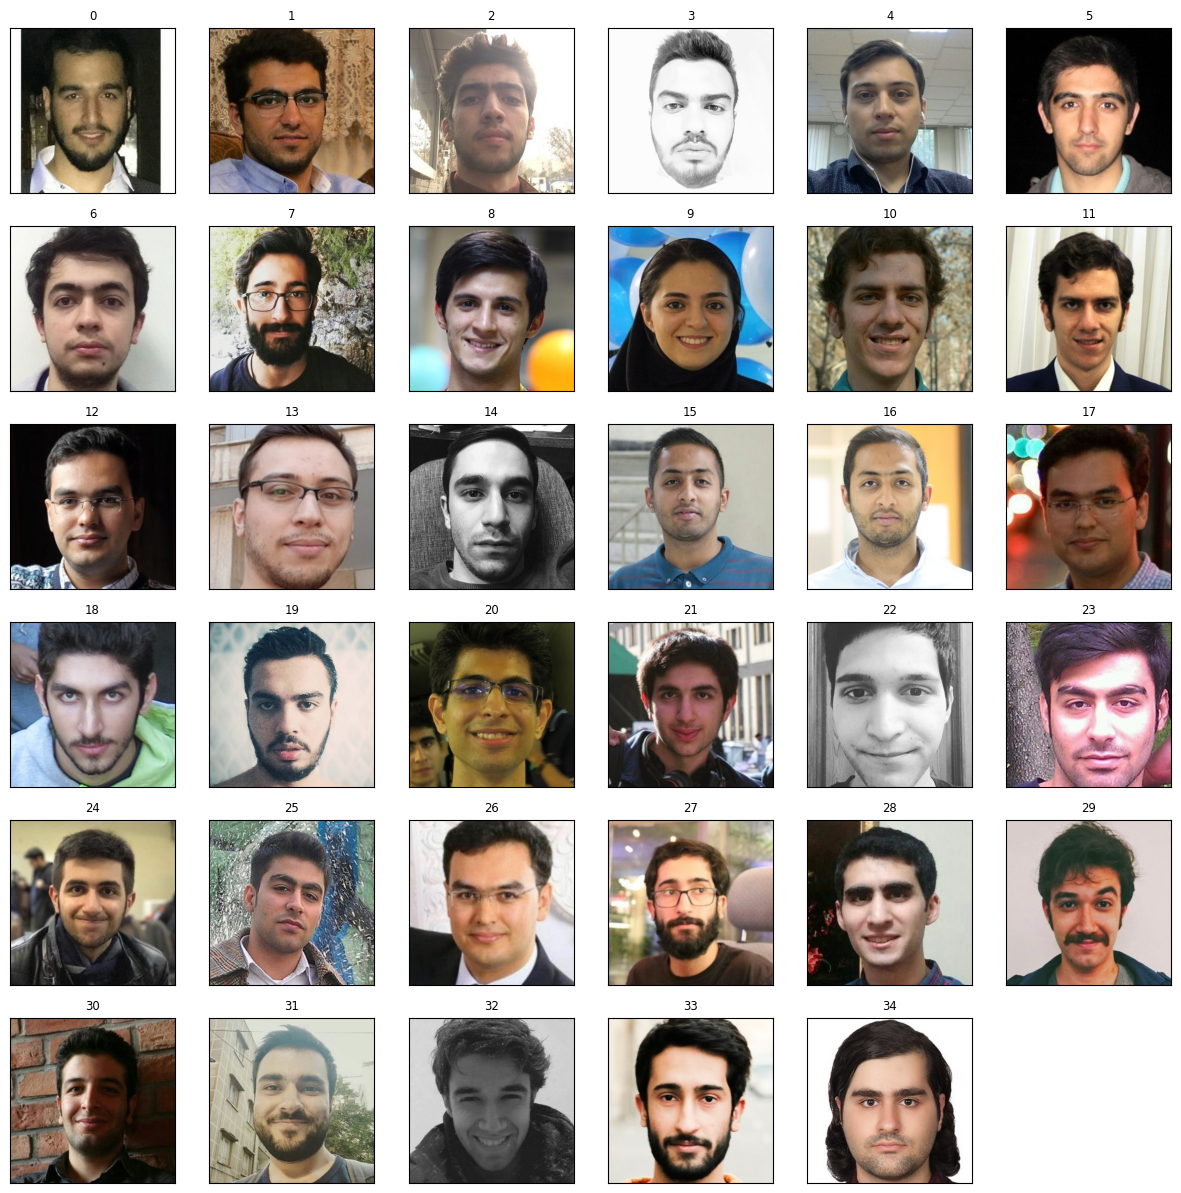

In [8]:
training_images = list(map(load_image, train_files))
training_images.pop(21) #retiro la imagen #21 debido a que no es de la misma dimension que las demas
show_grid_images(list_images=training_images)

# 2. Transformación de las matrices para el cárculo del rostro medio

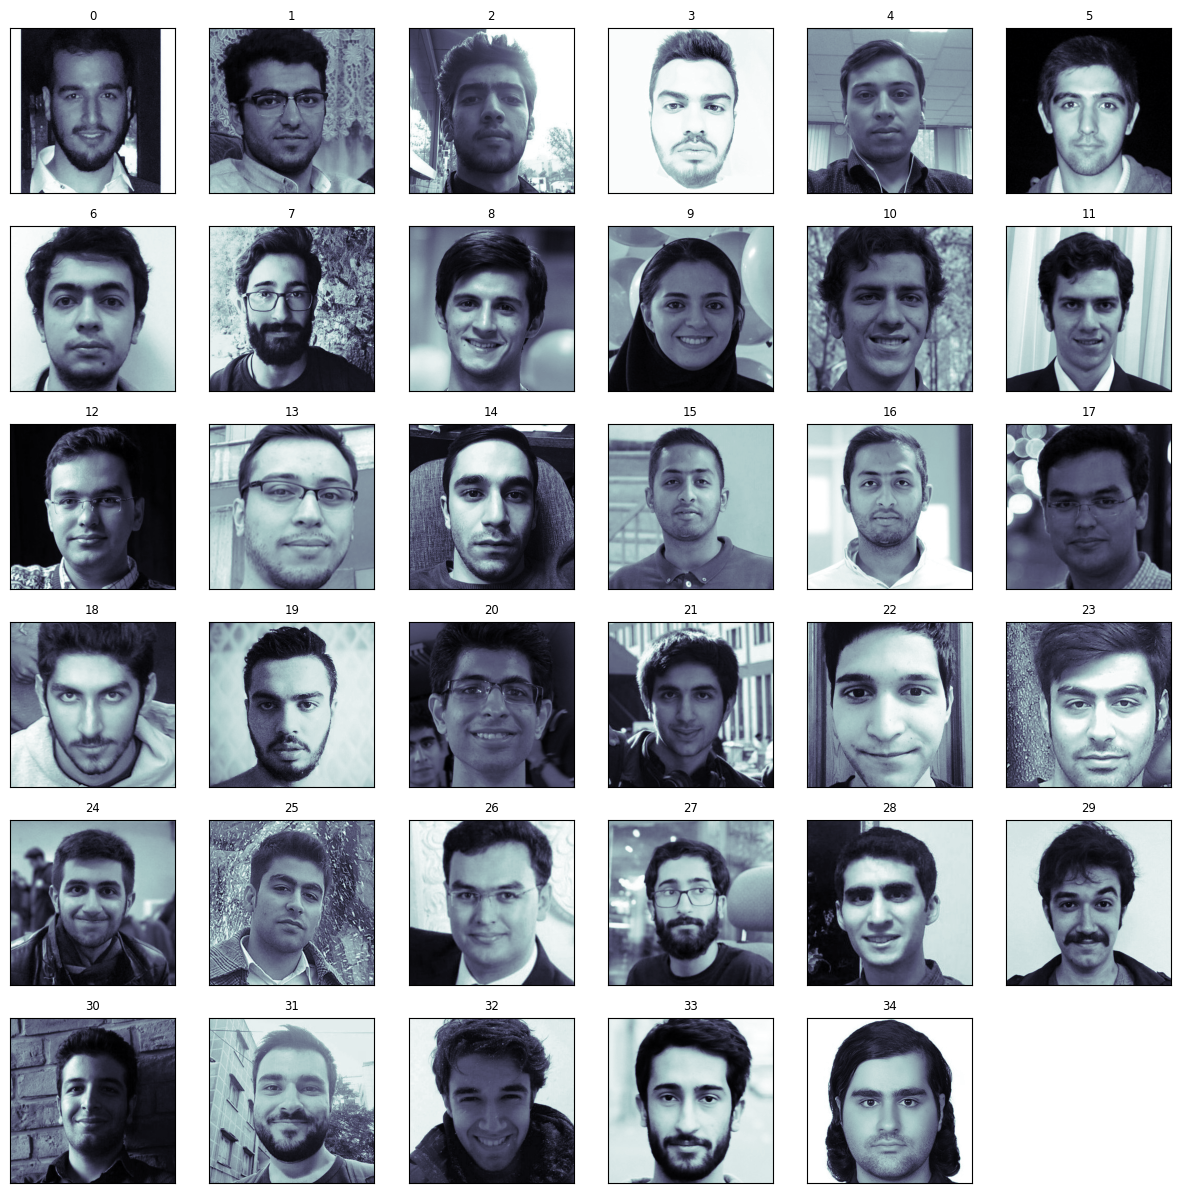

In [9]:
train_median_images = [np.mean(fix_img, axis=2) for fix_img in training_images]
show_grid_images(list_images=train_median_images)

## 3. Normalizando los rostros con la media de rostros transformados

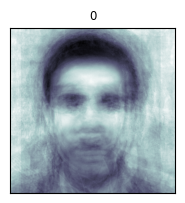

In [10]:
#Vectorize matrix
matrix_transformed_images = [np.matrix(matrix_transformed_images).flatten('F') for matrix_transformed_images in train_median_images] #vectorizado
# [m.shape for m in matrix_transformed_images]
sum_vectors = np.zeros((1, 102400)) # 320x320
for vector in matrix_transformed_images :
  if vector.shape == (1, 102400):
    sum_vectors += vector
    # show_grid_images([vector.reshape((320,320), order='F')])
average_vector = (1/(len(matrix_transformed_images)-1)) * sum_vectors

matrix_A = [vector_a - average_vector for vector_a in matrix_transformed_images]
show_grid_images([average_vector.reshape((320,320), order='F')])

#### this is a test

In [11]:
matrix_A = np.concatenate(matrix_A)
matrix_A = matrix_A.transpose()
matrix_A.shape

(102400, 35)

## 4. Aplicando SVD y verificando

In [12]:
U, S, Vh = np.linalg.svd(matrix_A, full_matrices=False)
X_a = U @ np.diag(S) @ Vh
print(np.std(matrix_A), np.std(X_a), np.std(matrix_A - X_a))
print('Son cercanos la matriz A con X_a?', np.isclose(matrix_A, X_a).all())

70.10471897512846 70.10471897512842 3.5925635137031636e-13
Son cercanos la matriz A con X_a? True


In [13]:
#Rango de la matriz
print("The Rank of a Matrix: ", np.linalg.matrix_rank(matrix_A))

The Rank of a Matrix:  35


In [14]:
X_i = [U.transpose() @ matrix_A[:,i] for i in range(35)] 
X_i[1].shape

(35, 1)

## 5. Cargando imagenes de prueba

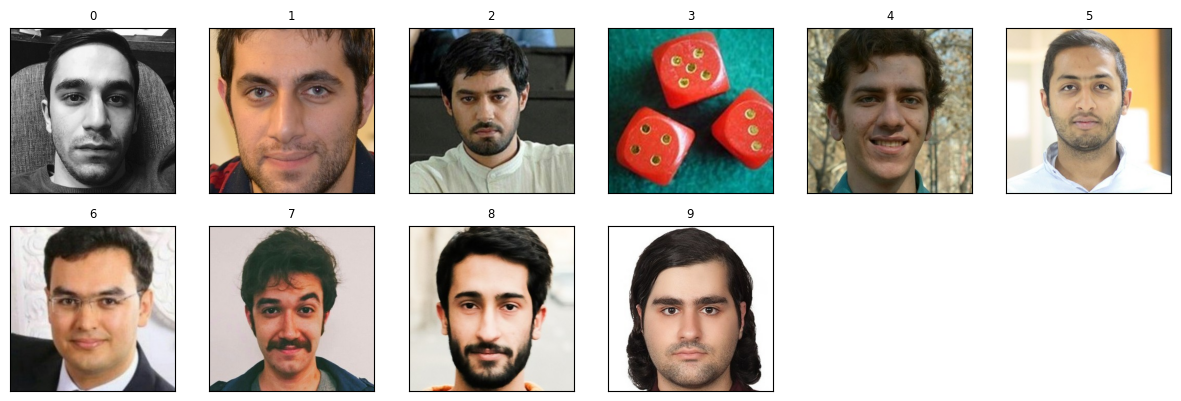

In [15]:
test_images = list(map(load_image, test_files))
show_grid_images(list_images=test_images)

Obtenos los rostros normalizados

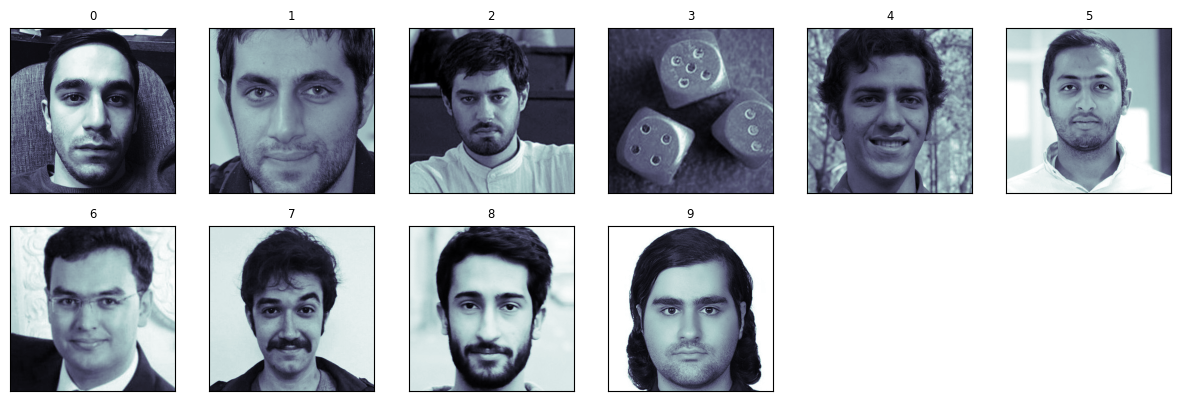

In [16]:
test_median_images = [np.mean(fix_img, axis=2) for fix_img in test_images]
show_grid_images(list_images=test_median_images)

In [17]:
test_images = [(np.matrix(image).flatten('F').transpose() - average_vector.transpose()) for image in test_median_images] #vectorizado - vector promedio
X_i_train_images = [U.transpose() @ test_images[i] for i in range(len(test_images))]

Seleccionamos el valor del umbral

In [18]:
umbral = 10000

In [20]:
from math import sqrt# Distancias

# X_i_imag = X_i_train_images[9]
# ans = X_i_imag - X_i[34]
# res = ans.transpose() @ ans
# sqrt(res[0, 0])

pairs = [] #pares de coincidencias
dados = [] #elementos desconocidos 
raices = []
k=1 #1, 2,3
for i in range(len(X_i_train_images)):
  X_i_imag = X_i_train_images[i]
  for j in range(len(X_i)):
    ans = X_i_imag - X_i[j]
    res = ans.transpose() @ ans # matrix([[ 123 ]])
    raiz = sqrt(res[0, 0])
    if raiz == 0: pairs.append((i, j))
    if i==k and raiz < 10000:
      dados.append((j, raiz))
    if i==k:
      raices.append((j, raiz))
# print(pairs)
# print(k, dados)
# print(raices)

print("Rostros Conocidos")
for pair in pairs:
  print (f" Foto de prueba {pair[0]} - Foto original {pair[1]}")

Rostros Conocidos
 Foto de prueba 0 - Foto original 14
 Foto de prueba 4 - Foto original 10
 Foto de prueba 7 - Foto original 29
 Foto de prueba 8 - Foto original 33
 Foto de prueba 9 - Foto original 34
